# Killswitch Analysis with Flow Cytometry Data
 *Garrett Newman*

Here, I will compare the cytometry results of the negative control to the results of Brandon Holt's RPT5-2 using Nick's Flow Cytometry Analysis Overview.

In [1]:
import FlowCytometryTools as fct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8

## RPT5-2 Data

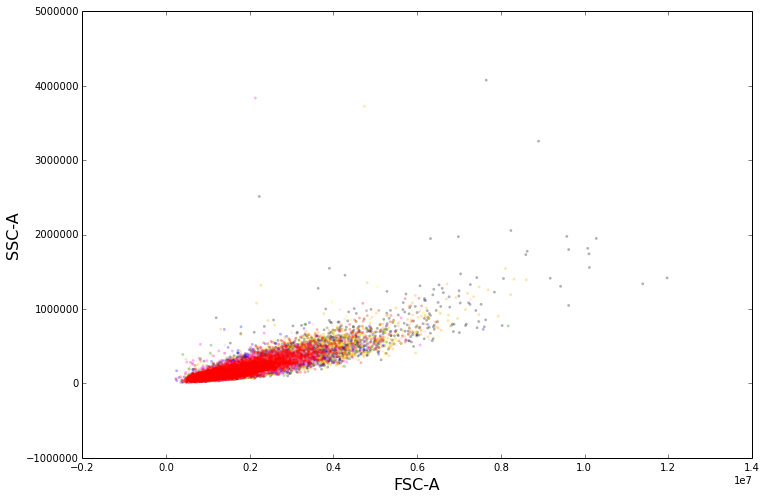

In [3]:
rows = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
row_colors = ['black', 'orange', 'yellow', 'green', 'blue', 'magenta', 'pink', 'red']
sample = []
for idx, row in enumerate(rows):
    sample_row = fct.FCMeasurement(ID='RPT5-2-{}'.format(row), datafile='./cytometry_results/Sample {}04.fcs'.format(row))
    sample_row.plot(('FSC-A', 'SSC-A'), kind='scatter', color=row_colors[idx], alpha=0.3, s=8);
    sample.append(sample_row)

Oddly, there doesn't seem to be any spray of dead cells. Regardless, we gate the data:

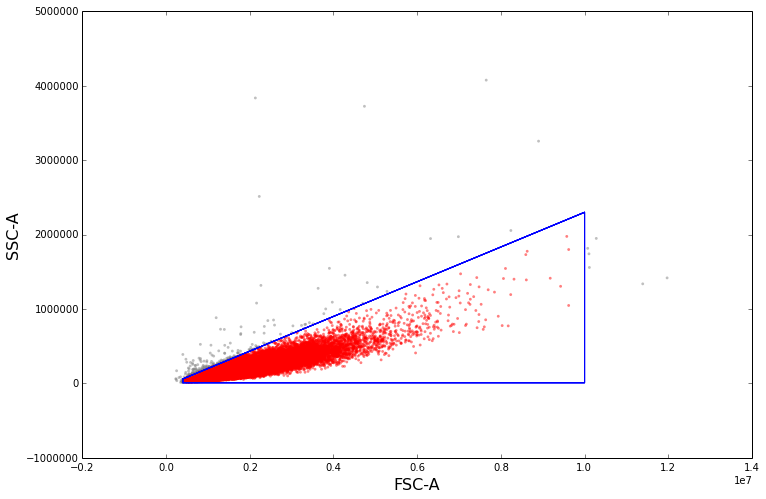

In [4]:
# A 2D Polygon Gate - just a set of vertices on the same attributes as above
yeast_gate = fct.PolyGate([(4e5, 1e4), (1e7, 1e4), (1e7, 23e5), (4e5, 6e4)], 
                          ('FSC-A', 'SSC-A'), 
                          region='in', 
                          name='poly gate')

yeast_sample = []
for sample_row in sample:
    # We can subset to the events within the gate, or to those outside of it
    yeast_sample_row = sample_row.gate(yeast_gate)
    notyeast_sample_row = sample_row.gate(~yeast_gate)

    # A visualization of our new yeast_gate
    yeast_sample_row.plot(('FSC-A', 'SSC-A'), gates=[yeast_gate], kind='scatter', color='red', alpha=0.5, s=8);
    notyeast_sample_row.plot(('FSC-A', 'SSC-A'), kind='scatter', color='gray', alpha=0.5, s=8);
    
    yeast_sample.append(yeast_sample_row)

Next, we gate in order to discriminate against yeast doublets:

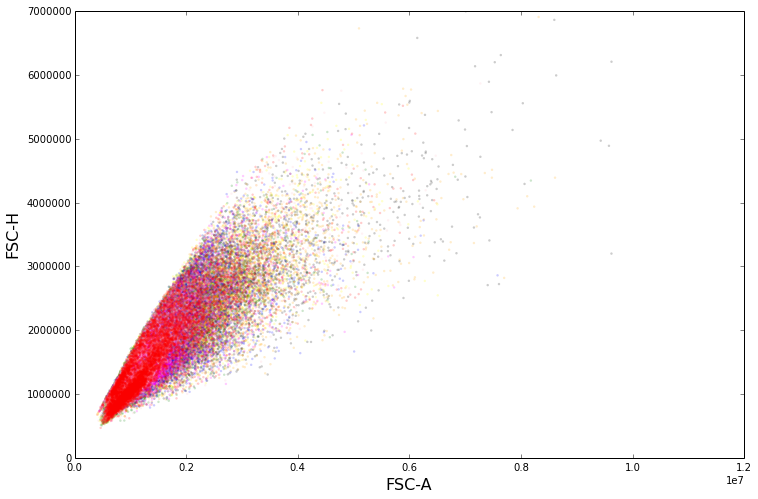

In [5]:
for idx, yeast_sample_row in enumerate(yeast_sample):
    yeast_sample_row.plot(('FSC-A', 'FSC-H'), kind='scatter', color=row_colors[idx], alpha=0.2, s=6)
    plt.ylim((0, 7e6))
    plt.xlim((0, 1.2e7))

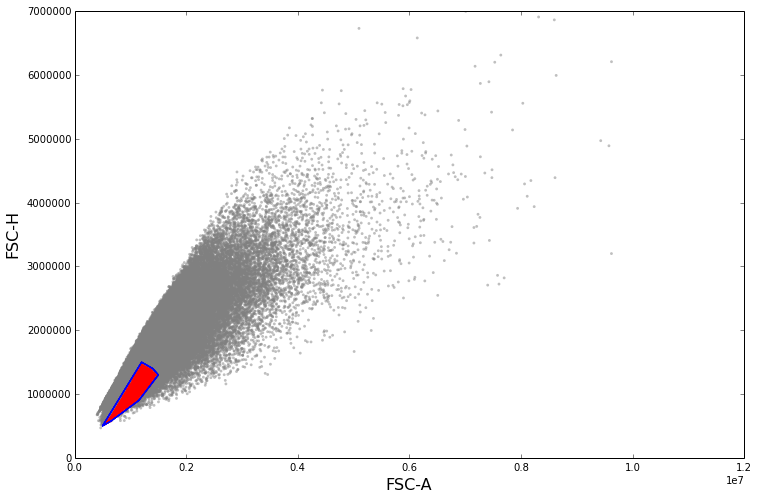

In [6]:
singlet_gate = fct.PolyGate([(6.5e5, 5.75e5), (1.15e6, 9e5), (1.5e6,1.3e6), (1.4e6, 1.4e6), (1.2e6, 1.5e6), (5e5, 5e5)], 
                            ('FSC-A', 'FSC-H'), 
                            region='in', 
                            name='singlets')

singlets_sample = []
for yeast_sample_row in yeast_sample:
    singlets_sample_row = yeast_sample_row.gate(singlet_gate)
    notsinglets_sample_row = yeast_sample_row.gate(~singlet_gate)

    singlets_sample_row.plot(('FSC-A', 'FSC-H'), gates=[singlet_gate], kind='scatter', color='red', alpha=0.5, s=8);
    notsinglets_sample_row.plot(('FSC-A', 'FSC-H'), kind='scatter', color='gray', alpha=0.5, s=8);
    plt.ylim((0, 7e6))
    plt.xlim((0, 1.2e7))
    
    singlets_sample.append(singlets_sample_row)

In [7]:
for idx in range(len(yeast_sample)):
    print 'Row {}: Number of yeast cells:'.format(rows[idx]), yeast_sample[idx].counts
    print 'Row {}: Number of single cells:'.format(rows[idx]), singlets_sample[idx].counts

Row A: Number of yeast cells: 10548
Row A: Number of single cells: 2115
Row B: Number of yeast cells: 10506
Row B: Number of single cells: 2195
Row C: Number of yeast cells: 10254
Row C: Number of single cells: 2925
Row D: Number of yeast cells: 10077
Row D: Number of single cells: 3051
Row E: Number of yeast cells: 10113
Row E: Number of single cells: 2435
Row F: Number of yeast cells: 10062
Row F: Number of single cells: 2842
Row G: Number of yeast cells: 10149
Row G: Number of single cells: 3160
Row H: Number of yeast cells: 10190
Row H: Number of single cells: 3190


Notably, in both replicate readings, the 1:10000 dilutions had appreciably more singlets per total cell count than did the 1:100 dilutions.

## RPT5-2 vs. Negative Control Analysis

In [8]:
# You can read in an entire 'plate' of FCS files at once, but you need to
# use a custom name parser
# The way that FCS files are parsed by default isn't compatible with
# the way C6 FCS files are named, so need a custom parser.
# Converts e.g. '/full/path/to/Sample C04.fcs' to 'C4'
import os
def parse_c6fcs(path):
    filename = os.path.basename(path)
    key_str = os.path.splitext(filename.strip('Sample '))[0]
    row = key_str[0]
    col = int(key_str[1:])
    return '{}{:01d}'.format(row, col)

# Note that I have placed all of the files in the /labw16/ folder, which anyone can read
plate1 = fct.FCPlate.from_dir(ID='plate1', path='/labw16/plate1/', parser=parse_c6fcs, position_mapper='name')

yeast_counts = plate1.gate(yeast_gate).counts()
yeast_counts

,1,2,3,4,5,6,7,8,9,10,11,12
A,10615,10162,10575,10548,10494,10504,10570,10531,78,NaN,NaN,NaN
B,10637,10566,10544,10506,10538,10530,10486,10403,513,NaN,NaN,NaN
C,10332,10326,10202,10254,10192,10325,10245,10117,122,NaN,NaN,NaN
D,10140,10093,10099,10077,10150,10122,10142,10091,18,NaN,NaN,NaN
E,10309,10294,10189,10113,10145,10172,10219,10144,32,NaN,NaN,NaN
F,10123,10096,10084,10062,10052,10040,10051,10196,132,NaN,NaN,NaN
G,10111,10098,10142,10149,10173,10134,10017,10088,1149,NaN,NaN,NaN
H,10249,10194,10181,10190,10167,10157,10105,10165,72,NaN,NaN,NaN


In [9]:
vol_list = plate1.get_measurement_metadata('$VOL')
concs = yeast_counts.copy()
for colname, value in vol_list.iteritems():
    row = colname[0]
    column = int(colname[1:])
    # Cytometer volume is in units of nanoliters
    ul_cyt = float(value) / 1000.0
    # Diluted sample 1:10 before reading
    ul = ul_cyt * 10
    concs.loc[row][column] = yeast_counts.loc[row][column] / ul
concs.columns = ['Strain {}'.format(col) for col in concs.columns]

concs

,Strain 1,Strain 2,Strain 3,Strain 4,Strain 5,Strain 6,Strain 7,Strain 8,Strain 9,Strain 10,Strain 11,Strain 12
A,486.480293,465.719523,440.441483,403.211009,400.840336,481.834862,606.077982,483.739090,0.155462,NaN,NaN,NaN
B,488.159706,484.901331,483.447960,482.147774,482.509158,439.115930,601.951780,595.477962,1.024893,NaN,NaN,NaN
C,278.115747,295.958727,274.542519,261.115355,291.867125,278.827977,276.518219,289.636416,0.243742,NaN,NaN,NaN
D,201.992032,256.688708,165.340537,230.700549,210.493571,221.052632,290.601719,220.231340,0.035964,NaN,NaN,NaN
E,472.673086,472.418541,576.953567,463.473877,465.366972,584.261918,425.969154,387.619412,0.063807,NaN,NaN,NaN
F,422.319566,355.743481,355.822159,271.652268,256.101911,219.213974,200.538707,424.302955,0.263731,NaN,NaN,NaN
G,243.814806,289.672978,202.354350,202.372881,245.309863,211.081025,169.779661,231.376147,2.290396,NaN,NaN,NaN
H,261.187564,259.455332,212.104167,245.957036,211.856637,221.671759,220.874317,222.234368,0.143529,NaN,NaN,NaN


In [10]:
np_concs = concs.as_matrix()

# Group the replicate readings in tuples for control and test strains
control_strain_raw = [(np_concs[idx][0], np_concs[idx+4][0]) for idx in range(0,4)]
test_strain_raw = [(np_concs[idx][3], np_concs[idx+4][3]) for idx in range(0,4)]

# Find mean and standard deviation for each strain test
strains_mean = [np.mean(readings) for readings in control_strain_raw + test_strain_raw]
strains_std = [np.std(readings) for readings in control_strain_raw + test_strain_raw]

# Group means and std devs by "untreated" and "treated"
untreated_mean = [strains_mean[idx*2] for idx in range(0, 4)]
treated_mean = [strains_mean[idx*2+1] for idx in range(0, 4)]
untreated_std = [strains_std[idx*2] for idx in range(0, 4)]
treated_std = [strains_std[idx*2+1] for idx in range(0, 4)]

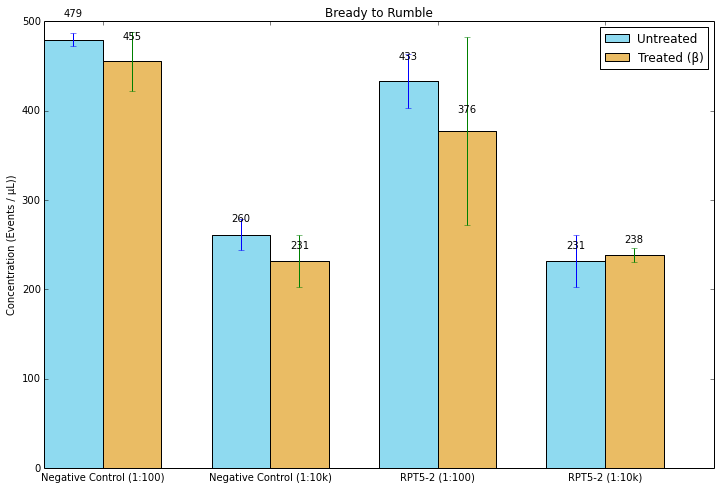

In [11]:
N = 4

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, untreated_mean, width, color='#8fdaf0', yerr=untreated_std)

rects2 = ax.bar(ind + width, treated_mean, width, color='#eabc64', yerr=treated_std)

# add some text for labels, title and axes ticks
ax.set_ylabel(u'Concentration (Events / µL))')
ax.set_title('Bready to Rumble')
ax.set_xticks(ind + width)
ax.set_xticklabels(('Negative Control (1:100)', 'Negative Control (1:10k)', 'RPT5-2 (1:100)', 'RPT5-2 (1:10k)'))

ax.legend((rects1[0], rects2[0]), ('Untreated', u'Treated (β)'))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

The results indicate that the "Kill Switch" did not work. If the switch had worked, the orange bars--representing the populations treated with β-estradiol--would ideally be significantly lower than the cyan bars. The error bars on this graph suggest that each bar of each pair is not sufficiently different from its neighboring bar, implying that β-estradiol had little to no effect on the growth rate and/or steady-state population of either the negative control strain or the "Kill Switch" strain.

Perhaps the suppressed gene, RPT5, is not as essential for survival as we would hope for this experiment, or perhaps it wasn't surpressed as much as it would need to be for us to see noticeable results. This could be due to secondary structures forming in the gRNA targeting a promoter sequence, the dCas9 not properly interfering with the transcription of the gene, or the gRNA being improperly designed.